# Diffusion-Limited Aggregation

## Objectives
- Simulate the stochastic growth of fractal structures using the Diffusion-Limited Aggregation model.
- Model Brownian motion (random walks) to understand how individual particle behavior leads to emergent complexity.
- Calculate the fractal dimension ($D$) of the resulting clusters to quantify their self-similarity and density.

In [2]:
import matplotlib.pyplot as plt
import numpy as np
rng = np.random.default_rng()
def initialize_grid(lat_dim): #Create grid
    lattice = np.zeros((lat_dim, lat_dim))
    lattice[int(lat_dim/2), int(lat_dim/2)] = 1

    return lattice

def choose_start(lat_dim, r_start, r_max): 
    #Choose a starting point at some random angle from the center
    #Point can go from r_max to r_start, r_max < r_start
    angle = rng.uniform()*2*np.pi
    
    radius = rng.uniform(r_max, r_start)
    
    start_x = lat_dim/2 + radius*np.cos(angle)
    start_y = lat_dim/2 + radius*np.sin(angle)
    
    return int(start_y), int(start_x) #Row, column index

def compute_r_max(lattice, lat_dim):
    #Compute the furthest point in the lattice with a value as the r_max
    particles_y, particles_x = np.where(lattice)
 
    particles_x = particles_x - int(lat_dim/2)
    particles_y = particles_y - int(lat_dim/2)

    p_distances = np.sqrt(particles_x**2 + particles_y**2)
    
    return np.max(p_distances)

def compute_r_start(lattice, lat_dim, pad):
    #Compute r_start a small distance from r_max, outputs both r_max and r_start
    r_max = compute_r_max(lattice, lat_dim)
    r_start = min((r_max + pad), lat_dim/2)
    return r_max, r_start

def check_position(lattice, lat_dim, x_pos, y_pos, r_start, r_kill, r_pad):
    #Check position of particle currently and act based on its current position
    r = np.sqrt((x_pos - int(lat_dim/2))**2 + (y_pos - int(lat_dim/2))**2)
    
    #Check if out of bounds
    if y_pos >= lat_dim or x_pos >= lat_dim:
        return "outbound"
    #Check if out of kill circle
    elif r > r_kill:
        return "kill"
    #Check if far from start but not outside of kill circle
    elif r > (r_start + r_pad):
        return "long_jump"
    #Check if there are neighbors
    elif (lattice[(y_pos+1)%lat_dim, x_pos] + lattice[(y_pos-1)%lat_dim, x_pos] + lattice[y_pos, (x_pos-1)%lat_dim] + lattice[y_pos, (x_pos+1)%lat_dim] > 0):
        return "stick"
    #Otherwise, random walk, step - 1
    else:
        return "jump"

def jump(x_pos, y_pos):
    #Random walk with step 1 for regions within r_start
    step = rng.choice(range(4))
    
    if step == 0:
        y_pos += 1
    elif step == 1:
        y_pos -= 1
    elif step == 2:
        x_pos += 1
    elif step == 3:
        x_pos -= 1
        
    return int(x_pos), int(y_pos)

def long_jump(lat_dim, x_pos, y_pos, r_start):
    #If particle is outside of r_start but not outside r_kill, jump a bigger distance
    r = np.sqrt((x_pos - int(lat_dim/2))**2 + (y_pos - int(lat_dim/2))**2)
    r_diff = r - r_start

    angle = rng.uniform()*2*np.pi
    
    new_x = r_diff * np.cos(angle) + x_pos
    new_y = r_diff * np.sin(angle) + y_pos
    
    return int(new_x), int(new_y)

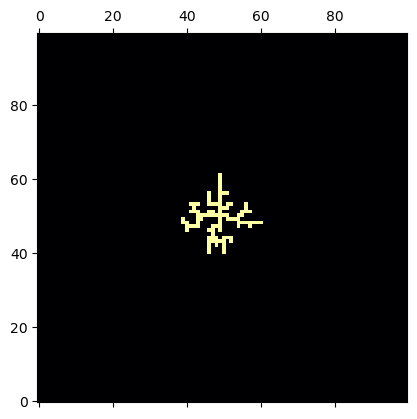

In [4]:
def random_walk(lat_dim, pad, target_size):
    lattice = initialize_grid(lat_dim)
    
    r_max, r_start = compute_r_start(lattice, lat_dim, pad)
    r_kill = lat_dim/2

    #Initialize number of particles
    N = 1
    
    N_list = []
    r_max_list = []
    x_pos, y_pos = choose_start(lat_dim, r_start = r_start, r_max = r_max)
    
    while (N < target_size) and (r_max < lat_dim/2):
        
        if y_pos >= lat_dim or x_pos >= lat_dim:
            x_pos, y_pos = choose_start(lat_dim, r_start = r_start, r_max = r_max) #Create a new walker

        elif lattice[y_pos,x_pos] == 1:
            #print("Spot occupied, choosing new pos")
            x_pos, y_pos = choose_start(lat_dim, r_start = r_start, r_max = r_max) #Create a new walker

        else:
            action = check_position(lattice, lat_dim, x_pos, y_pos, r_start, r_kill, pad)
            
            if action == "jump":
                x_pos, y_pos = jump(x_pos, y_pos)
                
            elif action == "long_jump":
                x_pos, y_pos = long_jump(lat_dim, x_pos, y_pos, r_start)
                
            elif action == "stick":
                lattice[y_pos, x_pos] = 1
                #print(f"Particle stuck to {x_pos, y_pos}")
                N += 1 
                r_max, r_start = compute_r_start(lattice, lat_dim, pad)
                #print(r_max, r_start)
                x_pos, y_pos = choose_start(lat_dim, r_start = r_start, r_max = r_max)
                N_list.append(N)
                r_max_list.append(r_max)
                r_max = int(r_max)
                r_start = int(r_start)

            elif action == "kill":
                x_pos, y_pos = choose_start(lat_dim, r_start = r_start, r_max = r_max) #Create a new walker

            elif action == "outbound":
                x_pos, y_pos = choose_start(lat_dim, r_start = r_start, r_max = r_max) #Create a new walker


    return lattice, N_list, r_max_list

lattice, N_list, r_max_list = random_walk(100, pad = 5, target_size = 100)
    
# -- Plotting only!
fig, ax = plt.subplots()
ax.matshow(lattice, origin="lower", cmap='inferno')
#ax.grid(True)

C:\Users\chris\AppData\Local\Temp\ipykernel_8632\1773744345.py:4: RuntimeWarning: invalid value encountered in divide
  D_list = np.log(np.array(N_list))/np.log(np.array(r_max_list))
C:\Users\chris\AppData\Local\Temp\ipykernel_8632\1773744345.py:4: RuntimeWarning: divide by zero encountered in divide
  D_list = np.log(np.array(N_list))/np.log(np.array(r_max_list))


Text(0, 0.5, 'D')

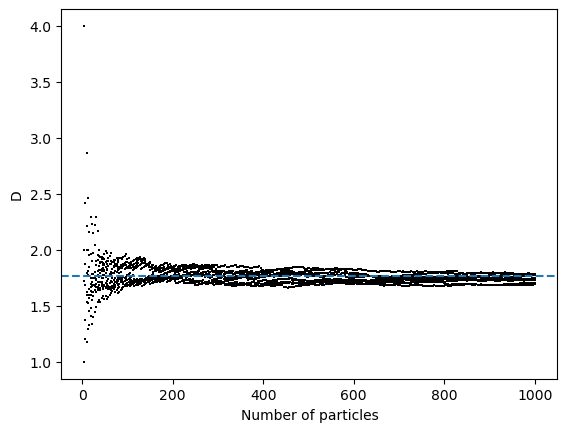

In [23]:
fig, ax = plt.subplots()
for realization in range(10):
    lattice, N_list, r_max_list = random_walk(500, pad = 10, target_size = 1000)
    D_list = np.log(np.array(N_list))/np.log(np.array(r_max_list)) 
    ax.scatter(N_list[3::3], D_list[3::3], marker = ',', s=1, linewidths=0, color = 'k')
ax.axhline(1.77, ls = '--')
ax.set_xlabel("Number of particles")
ax.set_ylabel("D")